In [42]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [43]:
def buildTrain(train, pastDay=5, futureDay=1):
    X_train, Y_train ,Z_train= [], [],[]
    for i in range(train.shape[0]-futureDay-pastDay+1):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["high"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay+futureDay-1]["high"]))
    return np.array(X_train), np.array(Y_train), np.array(Z_train)
def shuffle(X,Y,Z):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList],Z[randomList]
def splitData(X,Y,Z,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    Z_val = Z[:int(Z.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val,Z_val

In [44]:
train = pd.read_csv(r"C:\Users\admin\Desktop\Project\data\台北一\蔬果\奇異果-進口.csv")
train=train.drop(["Unnamed: 0"], axis=1)
train=train.drop(["crop_name"], axis=1)
train=train.drop(["crop_num"], axis=1)
train=train.drop(["market_name"], axis=1)
train=train.drop(["market_num"], axis=1)
temp=train
train= train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
train_x1,train_y1,train_z1=buildTrain(train)
train_x2,train_y2,train_z2=buildTrain(temp)
train_x,train_y,train_z=train_x1,train_y2,train_z2
train_x,train_y,train_z= shuffle(train_x,train_y,train_z)
train_x,train_y, val_x, val_y ,val_z= splitData(train_x,train_y,train_z, 0.075)

In [45]:
model = Sequential()
model.add(LSTM(150, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.35))
model.add(LSTM(50))
model.add(Dropout(0.35))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=32, validation_split=0.1, callbacks=[callback])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, return_sequences=True, input_shape=(5, 9))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 5, 150)            96000     
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 150)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                40200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 136,251
Trainable params: 136,251
Non-trainable params: 0
_________________________________________________________________
Trai

1776/1776 [==============================] - 1s 296us/step - loss: 1187.9909 - val_loss: 1503.1126
Epoch 64/300
1776/1776 [==============================] - 1s 299us/step - loss: 1184.4597 - val_loss: 1497.5329
Epoch 65/300
1776/1776 [==============================] - 1s 301us/step - loss: 1188.7915 - val_loss: 1509.2725
Epoch 66/300
1776/1776 [==============================] - 1s 291us/step - loss: 1188.6342 - val_loss: 1495.2435
Epoch 67/300
1776/1776 [==============================] - 1s 292us/step - loss: 1190.2479 - val_loss: 1489.9724
Epoch 68/300
1776/1776 [==============================] - 1s 295us/step - loss: 1204.8164 - val_loss: 1476.8238
Epoch 69/300
1776/1776 [==============================] - 1s 296us/step - loss: 1160.5998 - val_loss: 1423.7790
Epoch 70/300
1776/1776 [==============================] - 1s 316us/step - loss: 1129.9293 - val_loss: 1417.0014
Epoch 71/300
1776/1776 [==============================] - 1s 336us/step - loss: 1056.4102 - val_loss: 1380.2563
Epoch

accuracy:67.5%
accuracy(50%):29.375%


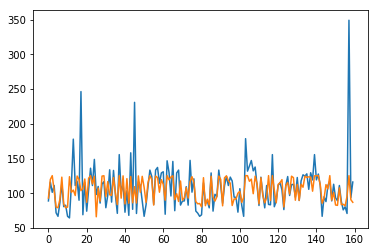

In [46]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
coo=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,5,9)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    sub=val_y[i]-val_z[i]
    sub_a=0.5*sub+val_z[i]
    sub_b=1.5*sub+val_z[i]
    sub2=val_z[i]-val_y[i]
    sub2_a=val_z[i]-0.5*sub2
    sub2_b=val_z[i]-1.5*sub2
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        if z>=sub_a and z<=sub_b:
            coo=coo+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        if z<=sub2_a and z>=sub2_b:
            coo=coo+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
acc2=100*(coo/val_x.shape[0])
print("accuracy(50%):"+str(acc2)+"%")
plt.show()